In [1]:
import numpy as np
import sobol_seq
import matplotlib.pyplot as plt
from functools import partial
from typing import List, Optional, Callable, Tuple


In [2]:
NP = 100 # number of population
FEs_max = NP*100 # maximum number of fitness evaluation
# F = 0.3 # mutation factor
# CR = 0.7 # crossover rate
Hm = 20 # maximum number of historical memories

# theta = 1e-3
tau_d = 1e-1 # distance radius
s_max = 20 # maximum archive size

F_init = 1.5
CR_init = 0.75

num_l = 100 # number of individuals in a subpopulation (cluster size)

dim = 2
boundaries = np.array([(-10,10) for _ in range (dim)])

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

def theta_increment(x):
    return 1/(np.exp(x))

In [3]:
def root_objective_function(x:np.ndarray):
    res = 0
    F_array = objective_function(x)
    for f in F_array:
        res +=(f)**2
    return res

#### Used repulsion function

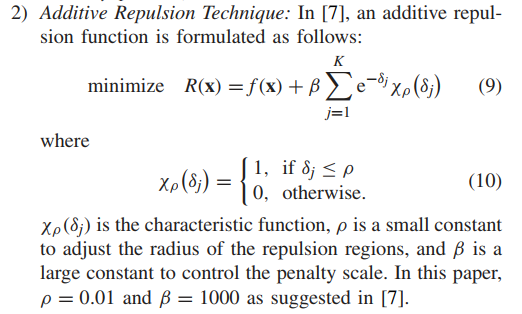

In [4]:
"""Characteristic Function"""
def chi_p(delta_j, rho):
    return 1 if delta_j <= rho else 0

"""Repulsion Function"""
def repulsion_function(x,
                       archive,
                       objective_func=root_objective_function,
                       beta=1000,
                       rho=0.01):
    f_x = objective_func(x)
    Rx = 0
    for x_star in archive:
        delta_j = np.linalg.norm(x-x_star)
        Rx += np.exp(-delta_j) * chi_p(delta_j, rho)
    Rx *= beta
    Rx += f_x
    return Rx

"""Fitness Function"""
def fitness_function(x,
                     archive,
                     objective_func=root_objective_function,
                     repulsion_func=repulsion_function):
    f_x = objective_func(x)
    if archive == []:
        return f_x
    else:
        return repulsion_func(x,archive)
    
# # Test the Functiuons
# arch = [np.array([1,2]),np.array([3,4]),np.array([-6.43,0.15])]
# x = np.array([-6.437160,0.155348])
# print(fitness_function(x,
#                        arch,
#                        objective_func=root_objective_function,
#                        repulsion_func=partial(repulsion_function,
#                                               objective_func = root_objective_function,
#                                               beta=1000,rho=0.01)))

In [5]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int,
                    npoint:int,
                    low=-10,
                    high=10):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    # Generate Sobol sequence points
    sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)

    # Scale the Sobol points to fit within the specified boundaries
    scaled_points = []
    for i in range(dim):
        a, b = boundaries[i]
        scaled_dim = a + sobol_points[:, i] * (b - a)
        scaled_points.append(scaled_dim)

    # Transpose the scaled points to get points per dimension
    scaled_points = np.array(list(map(list, zip(*scaled_points))))
    return scaled_points


Archive Updating

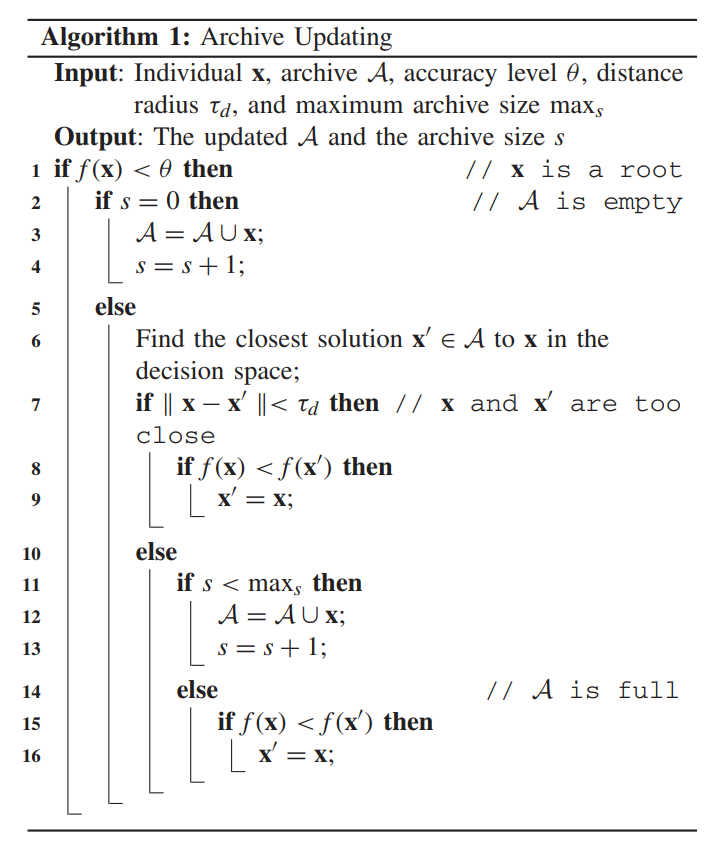

In [6]:
def update_archive(x: np.ndarray,
                   objective_function,
                   archive,
                   theta,
                   tau_d,
                   s_max):
    """Input"""
    # x : Individual
    # theta : accuracy level
    # tau_d : distance radius
    # s_max : maximum archive size
    # archive : archive
    # s : archive current size

    f_x = objective_function(x)
    s = len(archive) # archive current size
    # print(f'f_x= {f_x}')
    if f_x < theta: # x is a root
        
        if s == 0: # archive is empty
            archive.append(x)
            s+=1
        else:
            """Find the closest solution x_prime ∈ archive to x in the decision space"""
            dist_min = np.linalg.norm(x-archive[0])
            idx_min = 0
            x_prime= archive[idx_min]
            for i in range(1,len(archive)): 
                dist = np.linalg.norm(x-archive[i])
                if dist < dist_min:
                    dist_min = dist
                    x_prime = archive[i]
                    idx_min = i
            f_x_prime = root_objective_function(x_prime)
            if dist_min < tau_d: # x and x_prime are too close
                if f_x < f_x_prime:
                    x_prime = x
                    archive[idx_min] = x_prime
            else:
                if s < s_max:
                    archive.append(x)
                    s += 1
                else:       # archive is full
                    if f_x<f_x_prime:
                        x_prime = x
                        archive[idx_min] = x_prime
    return archive


# # Test the function
# x = np.array([-6.437160,0.155348]) # Individual
# theta = 1e-4 # accuracy level
# tau_d = 1e-1 # distance radius
# s_max = 3 # maximum archive size
# archive = [np.array([0,0]),np.array([1,2]),np.array([-6.4,0])] # archive
# update_archive(x,root_objective_function,archive,theta,tau_d,s_max)

In [7]:
def mutation(xr1,xr2,xr3,scaling_factor):
    donor_vector = xr1 + scaling_factor*(xr2-xr3)
    return donor_vector

def crossover(individual:np.ndarray, honor_vector:np.ndarray, crossover_rate):
    trial_vector = np.zeros(shape=individual.shape)
    for j in range (individual.shape[0]):
        rand_j = np.random.random() # a uniformly distributed random number from [0, 1]
        j_rand = np.random.randint(dim+1) #a random integer uniformly generated from {1, . . . , n}
        if (rand_j<crossover_rate) or (j == j_rand):
            trial_vector[j] = honor_vector[j]
        else: #(rand_j>=CR) and (j != j_rand)
            trial_vector[j] = individual[j]
    return trial_vector


In [8]:
"""Calculate Euclidean distances and select t closest individuals"""
def subpopulating(individual, 
                  population, 
                  t,
                  return_index = False,
                  show_distances = False): 
    """Input"""
    # individual
    # population
    # t: max number of units in a subpopulation

    """Algorithm"""
    # Calculate the Euclidean distances from the individual to all others in the population
    distances = np.sqrt(np.sum((population - individual) ** 2, axis=1))
    # Get the indices of the individuals with the smallest distances
    closest_indices = np.argsort(distances)[:t]
    # Form the subpopulation with the closest individuals
    subpop = population[closest_indices]

    if show_distances == True:
        print(f'Distance: \n{distances[:t]}')
    if return_index == True:
        if t == 1:
            return closest_indices,subpop.flatten()
        else:
            return closest_indices,subpop
    else:
        if t == 1:
            return subpop.flatten()
        else:
            return subpop

# # Test the function
# # Assuming P is a numpy array of individuals where each individual is a point in n-dimensional space
# np.random.seed(0)
# P = np.random.rand(100, 2)  # Example: 100 individuals in a 5-dimensional space
# print(P)
# print("")

# # The number of individuals to select with the smallest Euclidean distances
# t = 2
# # Forming subpopulations for each individual in P
# subpopulations = [subpopulating(xi, P, t) for xi in P]
# print(subpopulations)
# print("")

# # Now subpopulations is a list of numpy arrays, each containing the t closest individuals to each xi in P
# # For example, to access the subpopulation for the first individual in P:
# subpopulation_first_individual = subpopulations[0]
# print(subpopulation_first_individual)

# subpopulating(P[0],P,t,show_distances=True,return_index=False)


In [9]:
def update_parameter(M_F,
                     M_CR,
                     Hm:int):
    """Input"""
    # MF: Historical memories of scaling factor of DE as F
    # MCR:Historical memories crossover rate of DE as CR
    # Hm: Size of Historical Memories

    # Randomly select an index
    hi = np.random.randint(0, Hm)
    # Generate Fi using the Cauchy distribution with the location parameter MF[hi] and scale 0.1
    Fi = np.random.standard_cauchy() * 0.1 + M_F[hi]
    # Generate CRi using the Gaussian distribution with mean MCR[hi] and standard deviation 0.1
    CRi = np.random.normal(M_CR[hi], 0.1)
    # Ensure CRi is within the range [0, 1] and Fi is within the range [0,2]
    Fi = np.clip(Fi, 0, 1)
    CRi = np.clip(CRi, 0, 1)
    return Fi, CRi

# # Coba
# MF = [0.5, 0.6, 0.7, 0.8, 0.9] 
# MCR = [0.1, 0.2, 0.3, 0.4, 0.5]
# update_parameter(MF,MCR,len(MF))

In [10]:
def meanWL(elements, weights):
    """
    Calculate the weighted Lehmer mean of elements.
    Lehmer mean is calculated as the weighted sum of the squares
    divided by the weighted sum of the elements.
    """
    numerator = np.sum(np.multiply(np.square(elements), weights))
    denominator = np.sum(np.multiply(elements, weights))
    return numerator / denominator if denominator != 0 else 0

# Define the weighted arithmetic mean function
def meanWA(elements, weights):
    """
    Calculate the weighted arithmetic mean of elements.
    This is the standard weighted mean.
    """
    return np.average(elements, weights=weights)

def update_history(M_F,M_CR,S_F,S_CR,k):
    weights = np.array([1 for _ in range (len(S_F))])
    if len(S_F)!=0:
        M_F[k] = meanWL(S_F,weights) 
    if len(S_CR)!=0:
        M_CR[k] = meanWA(S_CR,weights)
    return M_F,M_CR


In [11]:
popA = generate_points(dim=dim,
                        npoint=NP,
                        low=boundaries[:,0],
                        high=boundaries[:,1])
f_x = root_objective_function([popA[:,0],popA[:,1]])
M_CR = np.ones(Hm)*CR_init
M_F = np.ones(Hm)*F_init
archiveA = []
FEs = NP
k = 0

#### Framework of RADE

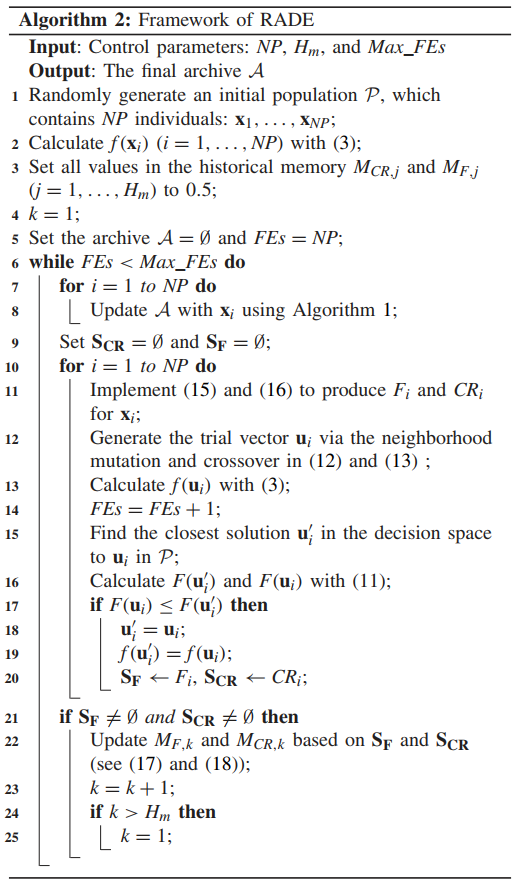

In [12]:
np.random.seed(0)
# theta = 0
while FEs < FEs_max:
    theta = 1
    for i in range (NP):
        # print(theta_increment(theta))
        # print(f'x={popA[i]}')
        archiveA = update_archive(x = popA[i],
                                    objective_function=root_objective_function,
                                    archive=archiveA,
                                    theta=theta,
                                    tau_d=tau_d,
                                    s_max=s_max)
        # theta *=0.7
        # print(f'archive= {archiveA}')
    S_F, S_CR = [],[]
    subpopA = np.array([subpopulating(xi, popA, num_l) for xi in popA])
    for i in range (NP):
        F_i,CR_i = update_parameter(M_F,M_CR,Hm)
        """GENERATE: three distinct individuals xr1, xr1, xr1 from the current population randomly"""
        x_i = popA[i]
        popB = subpopA[i].copy()
        pop_ids = np.arange(popB.shape[0])
        indices_to_delete = np.where(np.all(popB == x_i, axis=1))[0] # Ensure that x_i is excluded from the selected subpopulation
        subpop_ids_no_i = np.delete(pop_ids, indices_to_delete, axis=0)
        xr1,xr2,xr3 = popB[np.random.choice(subpop_ids_no_i,3,replace=False)] 

        """MUTATION: Form the donor/mutation vector"""
        dv_i = mutation(xr1,xr2,xr3,F_i)

        """CROSSOVER: The trial vector dv_i is developed either from the elements of the target vector xi or the elements of the donor vector vi"""
        tv_i = crossover(x_i,dv_i,CR_i)

        """Calculate root_objective_function on the trial function tv_i"""
        f_tv_i = root_objective_function(tv_i)

        """Add iteration for fitness function evaluation"""
        FEs +=1

        """Find the closest solution tv_i_prime in the decision space to tv_i in PopA"""
        id_tv_i_prime,tv_i_prime = subpopulating(tv_i,popA,1,show_distances=False,return_index=True)
        # print(f'i={i}\ntv_i: {tv_i}\nf_tv_i: {f_tv_i}\ntv_i_prime: {tv_i_prime}\nid_tv_i_prime: {id_tv_i_prime}\n')
        F_tv_i = fitness_function(tv_i,
                                archiveA,
                                objective_func=root_objective_function,
                                repulsion_func=partial(repulsion_function,
                                                        objective_func = root_objective_function,
                                                        beta=1000,rho=0.01))
        F_tv_i_prime = fitness_function(tv_i_prime,
                                        archiveA,
                                        objective_func=root_objective_function,
                                        repulsion_func=partial(repulsion_function,
                                                                objective_func = root_objective_function,
                                                                beta=1000,rho=0.01))
        # print(f'F_tv_i: {F_tv_i}\nF_tv_i_prime: {F_tv_i_prime}')
        if F_tv_i <= F_tv_i_prime:
            # print(f'popA: {popA[id_tv_i_prime]}')
            popA[id_tv_i_prime] = tv_i
            # print(f'popA: {popA[id_tv_i_prime]}')
            S_F.append(F_i)
            S_CR.append(CR_i)

    # print(f'S_F: {S_F}\nS_CR: {S_CR}')
    """Update parameter history"""
    if (len(S_F)!=0) & (len(S_CR)!=0):
        M_F,M_CR = update_history(M_F,M_CR,S_F,S_CR,k)
        # print(f'M_F: {M_F}\nM_CR: {M_CR}')
        k +=1
        if k >= Hm:
            k = 1

print(f'M_F: {M_F}\nM_CR: {M_CR}')
print(f'Archive: {archiveA}')

M_F: [0.98538886 0.84409474 0.88353848 0.85973346 0.89393918 0.8320985
 0.86685103 0.86814082 0.87700659 0.83667712 0.77793128 0.83105154
 0.8809892  0.91601659 0.84805817 0.84020822 0.83333205 0.89156601
 0.88785837 0.88335707]
M_CR: [0.77830842 0.67298844 0.67324445 0.67880125 0.70696556 0.6832688
 0.67975006 0.72350405 0.70206168 0.69169832 0.70528614 0.70305909
 0.69862077 0.70254747 0.70662301 0.64667761 0.68532991 0.69616497
 0.6878979  0.68647204]
Archive: [array([ 0.07203881, 37.87134173]), array([-11.88082497,  -0.32944432]), array([0.07432712, 6.09617039]), array([ 0.26028101, 14.88181409]), array([-28.71171858,   0.        ]), array([0.92359159, 0.51879114]), array([0.2627674 , 0.67976307]), array([-2.73136319, -1.9482527 ]), array([ 0.50057172, -1.98893084]), array([-3.82150716,  0.31413457]), array([2.24660419, 2.97575736]), array([-1.89024083,  2.70676571]), array([-7.21490526, -0.10285431]), array([0.02910964, 1.73767718]), array([ 0.03124282, 19.74479758]), array([1.535